In [1]:
import numpy as np
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
n = dataset[0].num_nodes

In [4]:
# グラフ畳み込みネットワークの定義
class GCN(torch.nn.Module):
    def __init__(self, in_d, mid_d, out_d):
        super().__init__()
        self.conv1 = GCNConv(in_d, mid_d)
        self.conv2 = GCNConv(mid_d, out_d)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        emb = x.detach()
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), emb

In [5]:
model = GCN(dataset.num_node_features, 16, dataset.num_classes)

In [6]:
data = dataset[0]
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

In [7]:
def train(epoch):
    model.train()
    for epoch in range(epoch):
        optimizer.zero_grad()
        out = model(data)[0]
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

In [8]:
%time train(500)

CPU times: user 16.8 s, sys: 123 ms, total: 17 s
Wall time: 1.43 s


In [9]:
model.eval()
pred = model(data)[0].argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
acc

0.805

In [10]:
G = nx.Graph()
for i in range(n):
    G.add_node(i)
for i in range(data.edge_index.shape[1]):
    G.add_edge(int(data.edge_index[0, i]), int(data.edge_index[1, i]))

In [11]:
# ラベル色設定
colors = [
    '#ff4b00',
    '#03af7a',
    '#005aff',
    '#4dc4ff',
    '#f6aa00',
    '#990099',
    '#804000'
]
cs = [
    colors[y] for y in data.y
]

In [12]:
emb = model(data)[1].numpy()
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate="auto")
emb_tsne = tsne.fit_transform(emb)

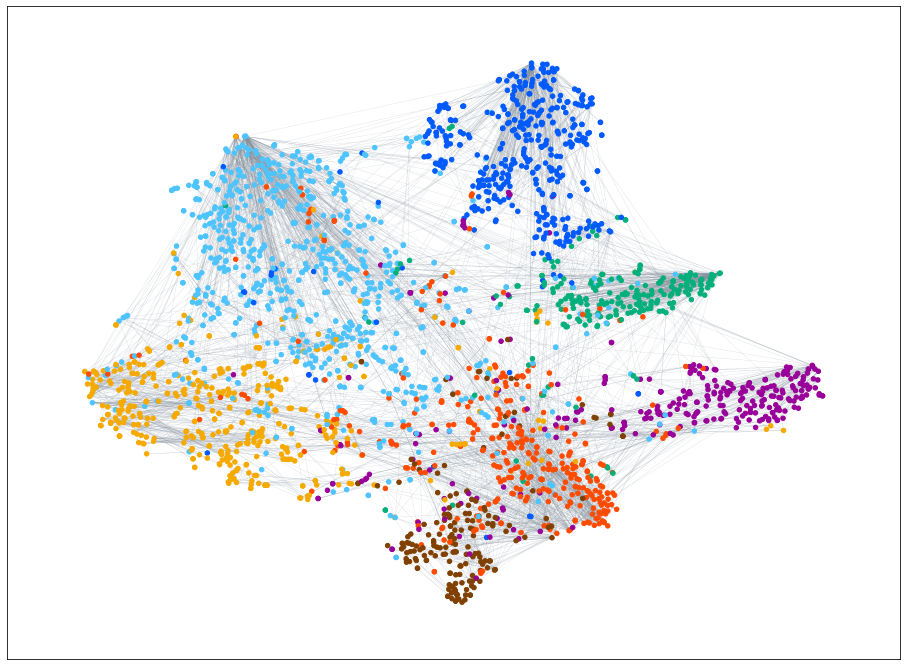

In [13]:
# GCN の埋め込み可視化
fig, ax = plt.subplots(figsize=(16, 12))
nx.draw_networkx(G, ax=ax, pos=emb_tsne, node_size=20, node_color=cs, labels={i: '' for i in range(n)}, edge_color='#84919e', width=0.1)

In [14]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(data.x)

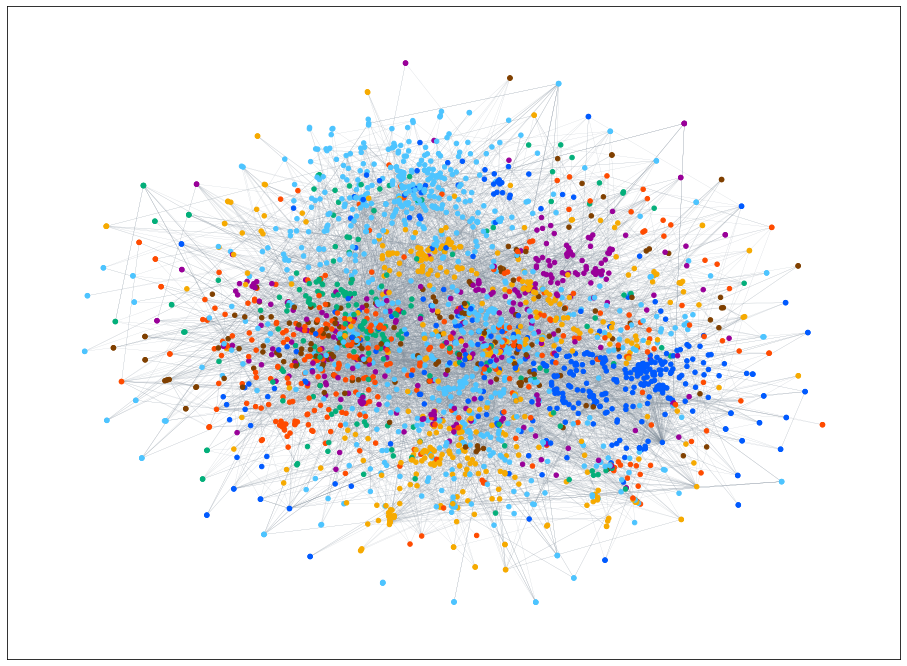

In [15]:
# 頂点特徴 X の可視化
fig, ax = plt.subplots(figsize=(16, 12))
nx.draw_networkx(G, ax=ax, pos=X_tsne, node_size=20, node_color=cs, labels={i: '' for i in range(n)}, edge_color='#84919e', width=0.1)

In [16]:
H = (data.x @ model.conv1.lin.weight.T).detach().numpy()
tsne = TSNE(n_components=2, random_state=0)
H_tsne = tsne.fit_transform(H)

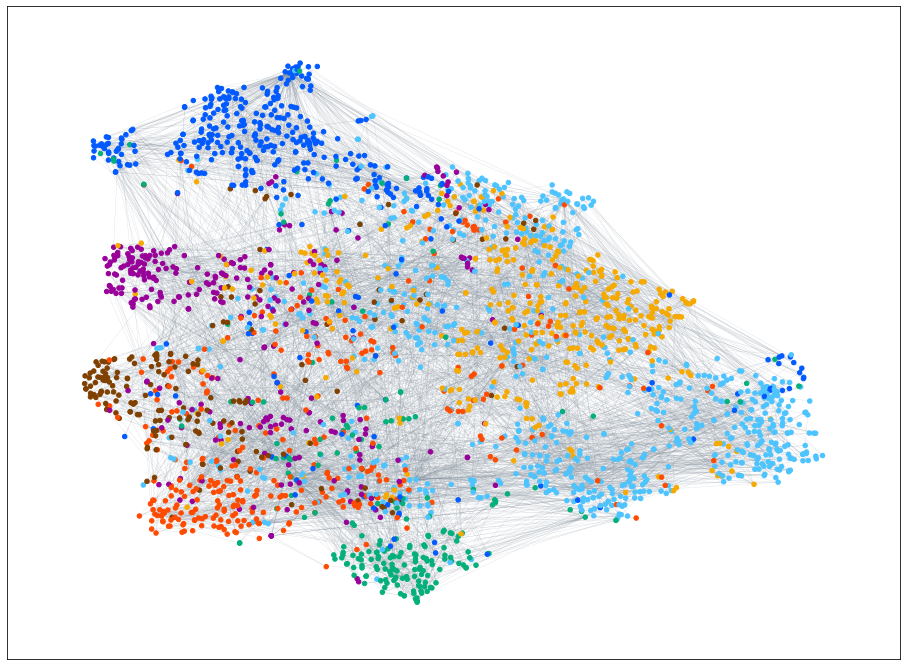

In [17]:
# GCN において集約の直前の埋め込みの可視化
fig, ax = plt.subplots(figsize=(16, 12))
nx.draw_networkx(G, ax=ax, pos=H_tsne, node_size=20, node_color=cs, labels={i: '' for i in range(n)}, edge_color='#84919e', width=0.1)